## ECGR5106 - HW 2

In [1]:
!pip install d2l==1.0.0b0
!pip install ptflops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.6/141.6 KB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 28.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 KB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.6/155.6 KB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.0/121.0 KB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 KB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 64.3 MB/s eta 0:00:00
  Created wheel for gym: filename=gym-0.21.0-py3-none-any.whl size=1616822 sha256=03796462d602fba5beeb1169bf286d3112121525e7eb0dad0f50be37cf6736f8
  Stored in directory: /root/.cache/pip/wheels/27/6d/b3/a3a6e10704795c9b9000f1ab2dc480dfe7bed42f5972806e73
Successfully built gym
  Attempting uninsta

In [2]:
# Importing all the Necessary Libraries

%matplotlib inline
import pandas as pd
import numpy as np
import ptflops

import matplotlib.pyplot as plt
import torch
import time
import torchvision
import torch.nn.functional as F   
from torchvision import transforms
from d2l import torch as d2l
from torch import nn
import torchvision.models as models
from ptflops import get_model_complexity_info

import torch
torch.__version__
torch.cuda.current_device()
torch.cuda.get_device_name(0)

d2l.use_svg_display()

# Code Snippet to Ignore Warning

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Loading the FashionMNIST Dataset 
class FashionMNIST(d2l.DataModule): 
  def __init__(self, batch_size = 64, resize = (28, 28)):
    super().__init__()
    self.save_hyperparameters()
    trans = transforms.Compose([transforms.Resize(resize),
                                transforms.ToTensor()])
    self.train = torchvision.datasets.FashionMNIST(
        root = self.root, train = True, transform = trans, download = True)
    self.val = torchvision.datasets.FashionMNIST(
        root = self.root, train = False, transform = trans, download = True)

In [4]:
# Resizing the Images to 32x32
data = FashionMNIST(resize = (32, 32))
# Printing the # of Training & Validation Images
print("Training Images   = ", len(data.train))
print("Validation Images = ", len(data.val))

data.train[0][0].shape

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw

Training Images   =  60000
Validation Images =  10000


torch.Size([1, 32, 32])

In [5]:
# Function that Converts the Numeric Labels to 10 Different Class Names
@d2l.add_to_class(FashionMNIST)
def text_labels(self, indices):
  labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat', 
           'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
  return [labels[int(i)] for i in indices]

# Function to load either Training or Validation self
@d2l.add_to_class(FashionMNIST)
def get_dataloader(self, train):
  data = self.train if train else self.val
  return torch.utils.data.DataLoader(data, self.batch_size, shuffle = train,
                                     num_workers = self.num_workers)
  
X, Y = next(iter(data.train_dataloader()))
print(X.shape, X.dtype, Y.shape, Y.dtype)

torch.Size([64, 1, 32, 32]) torch.float32 torch.Size([64]) torch.int64


In [6]:
# Function that initialized the weights of the CNN model with Xavier Uniform Initialization
def init_cnn(module):  
    """Initialize weights for CNNs."""
    if type(module) == nn.Linear or type(module) == nn.Conv2d:
        nn.init.xavier_uniform_(module.weight)

# The Baseline Convolution Neural Network 
class LeNet(d2l.Classifier):  
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.Sigmoid(),
            nn.LazyLinear(84), nn.Sigmoid(),
            nn.LazyLinear(num_classes))

In [7]:
# Function to print a Model's Layer Summary given the shape
@d2l.add_to_class(d2l.Classifier) 
def layer_summary(self, X_shape):
    X = torch.randn(*X_shape)
    for layer in self.net:
        X = layer(X)
        print(layer.__class__.__name__, 'output shape:\t', X.shape)

model = LeNet()
model.layer_summary((1, 1, 32, 32))
# Printing the total Number of MACs and Parameters for the Model
macs, params = ptflops.get_model_complexity_info(model.net, (1, 32, 32))
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

Conv2d output shape:	 torch.Size([1, 6, 32, 32])
Sigmoid output shape:	 torch.Size([1, 6, 32, 32])
AvgPool2d output shape:	 torch.Size([1, 6, 16, 16])
Conv2d output shape:	 torch.Size([1, 16, 12, 12])
Sigmoid output shape:	 torch.Size([1, 16, 12, 12])
AvgPool2d output shape:	 torch.Size([1, 16, 6, 6])
Flatten output shape:	 torch.Size([1, 576])
Linear output shape:	 torch.Size([1, 120])
Sigmoid output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
Sigmoid output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])
Sequential(
  82.83 k, 100.000% Params, 596.35 KMac, 100.000% MACs, 
  (0): Conv2d(156, 0.188% Params, 159.74 KMac, 26.787% MACs, 1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): Sigmoid(0, 0.000% Params, 0.0 Mac, 0.000% MACs, )
  (2): AvgPool2d(0, 0.000% Params, 6.14 KMac, 1.030% MACs, kernel_size=2, stride=2, padding=0)
  (3): Conv2d(2.42 k, 2.917% Params, 347.9 KMac, 58.339% MACs, 6, 16, kernel_size=(5, 5), stride=(1,

In [8]:
# Function to Evaluate the Model's Accuracy
def evaluate_accuracy_gpu(net, data_iter, device=None):
    if isinstance(net, nn.Module):
        net.eval()  
        if not device:
            device = next(iter(net.parameters())).device

    # No. of correct predictions, no. of predictions
    metric = d2l.Accumulator(2)

    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [9]:
# Training Function 
def train(net, train_iter, val_iter, num_epochs, lr, device):
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'val acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        val_acc = evaluate_accuracy_gpu(net, val_iter)
        animator.add(epoch + 1, (None, None, val_acc))

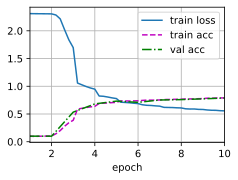

In [ ]:
# Plotting the Baseline LeNet Model over 10 Epochs
# This plot contains trainging Loss,Training Accuracy, and Test (Validation) Accuracy
lr, num_epochs = 0.1, 10
train(model.net, data.get_dataloader(True), data.get_dataloader(False), num_epochs, lr, d2l.try_gpu())

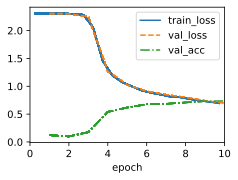

In [ ]:
# Plotting the Baseline LeNet Model over 10 Epochs
# This plot contains Training Loss, Validation Loss, and Validation Accuracy
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model = LeNet(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model, data)

## Problem # 1

LeNet will be Modernized. Following changes will be Implemented and tested over FashionMNIST Dataset.

1. The average pooling will be replaced with max-pooling.
2. The Sigmoid() layer will be replaced with ReLU()

Training will be started from scratch based on FashionMNIST. The training Loss, Training Accuracy, and Validation Accuracy will be compared against the baseline model.

In [ ]:
# Modernized LeNet Model for Problem # 1
# For Problem # 1, The Average Pooling will be replaced with Max Pooling,
# and the Softmax/Sigmoid layer with ReLU

class LeNet_Prob1(d2l.Classifier):  
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.ReLU(),
            nn.LazyLinear(84), nn.ReLU(),
            nn.LazyLinear(num_classes))

model = LeNet_Prob1()
model.layer_summary((1, 1, 32, 32))

Conv2d output shape:	 torch.Size([1, 6, 32, 32])
ReLU output shape:	 torch.Size([1, 6, 32, 32])
MaxPool2d output shape:	 torch.Size([1, 6, 16, 16])
Conv2d output shape:	 torch.Size([1, 16, 12, 12])
ReLU output shape:	 torch.Size([1, 16, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 16, 6, 6])
Flatten output shape:	 torch.Size([1, 576])
Linear output shape:	 torch.Size([1, 120])
ReLU output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
ReLU output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


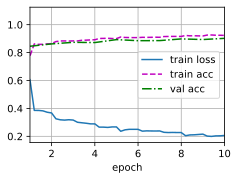

In [ ]:
lr, num_epochs = 0.1, 10
train(model.net, data.get_dataloader(True), data.get_dataloader(False), num_epochs, lr, d2l.try_gpu())

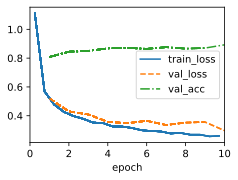

In [ ]:
# Plotting the Modernized LeNet Model over 10 Epochs
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model = LeNet_Prob1(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model, data)

## Problem 2

For Problem 2, the size of the LeNet style network will be changed to improve its accurcy in addition to max-pooling and ReLU.

1. The Convolution window size will be adjusted.
2. The Number of Output Channels will be adjusted.
3. The Number of Convolution Layers will be adjusted.
4. The Number of Fully Connected Layers will be adjusted.
5. The Learning Rate will be explored.

For all training adjustments, training will be restarted from scratch based on FashionMNIST. The training loss, training accuracy and validation accuracy will be compared against each other and the baseline model in Problem 1. 

Theoretical Computation Complexity will be measured and compared using ptflops.

## Model # 1 (Experimentation with Convolution Window Size) 

In [ ]:
# Changed Configurations for Problem 2
# For Part a, The Convolution Window size will be increased from 5 to 7 and then to 9,
# and the padding from 2 to 3

class LeNet_Prob2_Parta(d2l.Classifier):  
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=9, padding=3), nn.ReLU(),
            nn.MaxPool2d(kernel_size=7, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.ReLU(),
            nn.LazyLinear(84), nn.ReLU(),
            nn.LazyLinear(num_classes))

model = LeNet_Prob2_Parta()
model.layer_summary((1, 1, 32, 32))
# Printing the total Number of MACs and Parameters for the Model
macs, params = ptflops.get_model_complexity_info(model.net, (1, 32, 32))
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

Conv2d output shape:	 torch.Size([1, 6, 30, 30])
ReLU output shape:	 torch.Size([1, 6, 30, 30])
MaxPool2d output shape:	 torch.Size([1, 6, 12, 12])
Conv2d output shape:	 torch.Size([1, 16, 8, 8])
ReLU output shape:	 torch.Size([1, 16, 8, 8])
MaxPool2d output shape:	 torch.Size([1, 16, 4, 4])
Flatten output shape:	 torch.Size([1, 256])
Linear output shape:	 torch.Size([1, 120])
ReLU output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
ReLU output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])
Sequential(
  44.76 k, 100.000% Params, 652.33 KMac, 100.000% MACs, 
  (0): Conv2d(492, 1.099% Params, 442.8 KMac, 67.880% MACs, 1, 6, kernel_size=(9, 9), stride=(1, 1), padding=(3, 3))
  (1): ReLU(0, 0.000% Params, 5.4 KMac, 0.828% MACs, )
  (2): MaxPool2d(0, 0.000% Params, 5.4 KMac, 0.828% MACs, kernel_size=7, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(2.42 k, 5.397% Params, 154.62 KMac, 23.703% MACs, 6, 16, kernel_size=(5, 5), 

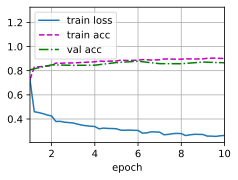

In [ ]:
lr, num_epochs = 0.1, 10
train(model.net, data.get_dataloader(True), data.get_dataloader(False), num_epochs, lr, d2l.try_gpu())

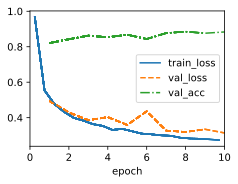

In [ ]:
# Plotting the Model over 10 Epochs
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model = LeNet_Prob2_Parta(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model, data)

## Model # 2 (Experimentation with the Number of Output Channels)

In [ ]:
 # Changed Configurations for Problem 2
# For Part b, The Number of Output Channels will be changed for both the Convolution Layers

class LeNet_Prob2_Partb(d2l.Classifier):  
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(8, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.ReLU(),
            nn.LazyLinear(84), nn.ReLU(),
            nn.LazyLinear(num_classes))

model = LeNet_Prob2_Partb()
model.layer_summary((1, 1, 32, 32))
# Printing the total Number of MACs and Parameters for the Model
macs, params = ptflops.get_model_complexity_info(model.net, (1, 32, 32))
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

Conv2d output shape:	 torch.Size([1, 8, 32, 32])
ReLU output shape:	 torch.Size([1, 8, 32, 32])
MaxPool2d output shape:	 torch.Size([1, 8, 16, 16])
Conv2d output shape:	 torch.Size([1, 16, 12, 12])
ReLU output shape:	 torch.Size([1, 16, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 16, 6, 6])
Flatten output shape:	 torch.Size([1, 576])
Linear output shape:	 torch.Size([1, 120])
ReLU output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
ReLU output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])
Sequential(
  83.68 k, 100.000% Params, 777.55 KMac, 100.000% MACs, 
  (0): Conv2d(208, 0.249% Params, 212.99 KMac, 27.393% MACs, 1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU(0, 0.000% Params, 8.19 KMac, 1.054% MACs, )
  (2): MaxPool2d(0, 0.000% Params, 8.19 KMac, 1.054% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(3.22 k, 3.843% Params, 463.1 KMac, 59.560% MACs, 8, 16, kernel_size=(5

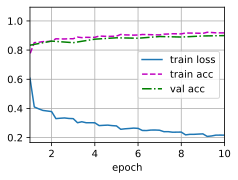

In [ ]:
lr, num_epochs = 0.1, 10
train(model.net, data.get_dataloader(True), data.get_dataloader(False), num_epochs, lr, d2l.try_gpu())

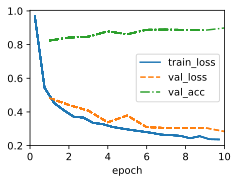

In [ ]:
# Plotting the Model over 10 Epochs
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model = LeNet_Prob2_Partb(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model, data)

## Model # 3 (Experimentation with the Number of Convolution Layers)

In [ ]:
class LeNet_ConvLayers(d2l.Classifier):  
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(32,kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(64,kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.ReLU(),
            nn.LazyLinear(84), nn.ReLU(),
            nn.LazyLinear(num_classes))

model = LeNet_ConvLayers()
model.layer_summary((1, 1, 32, 32))
# Printing the total Number of MACs and Parameters for the Model
macs, params = ptflops.get_model_complexity_info(model.net, (1, 32, 32))
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

Conv2d output shape:	 torch.Size([1, 6, 32, 32])
ReLU output shape:	 torch.Size([1, 6, 32, 32])
MaxPool2d output shape:	 torch.Size([1, 6, 16, 16])
Conv2d output shape:	 torch.Size([1, 16, 12, 12])
ReLU output shape:	 torch.Size([1, 16, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 16, 6, 6])
Conv2d output shape:	 torch.Size([1, 32, 6, 6])
ReLU output shape:	 torch.Size([1, 32, 6, 6])
MaxPool2d output shape:	 torch.Size([1, 32, 3, 3])
Conv2d output shape:	 torch.Size([1, 64, 3, 3])
ReLU output shape:	 torch.Size([1, 64, 3, 3])
MaxPool2d output shape:	 torch.Size([1, 64, 1, 1])
Flatten output shape:	 torch.Size([1, 64])
Linear output shape:	 torch.Size([1, 120])
ReLU output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
ReLU output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])
Sequential(
  85.48 k, 100.000% Params, 1.47 MMac, 100.000% MACs, 
  (0): Conv2d(156, 0.182% Params, 159.74 KMac, 10.864% MACs, 1, 6, kernel_size=(5, 5), stride=(

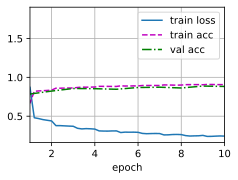

In [ ]:
lr, num_epochs = 0.1, 10
train(model.net, data.get_dataloader(True), data.get_dataloader(False), num_epochs, lr, d2l.try_gpu())

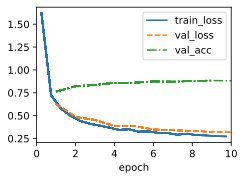

In [ ]:
# Plotting the LeNet Model with 2 more added Convolutional Layers over 10 Epochs
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model = LeNet_ConvLayers(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model, data)

## Model # 4 (Experimentation with the Number of Fully Connected Layers)

In [ ]:
class LeNet_FullyConnLayers(d2l.Classifier):  
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(256), nn.ReLU(),
            nn.LazyLinear(128), nn.ReLU(),
            nn.LazyLinear(64), nn.ReLU(),
            nn.LazyLinear(16), nn.ReLU(),
            nn.LazyLinear(num_classes))

model = LeNet_FullyConnLayers()
model.layer_summary((1, 1, 32, 32))
# Printing the total Number of MACs and Parameters for the Model
macs, params = ptflops.get_model_complexity_info(model.net, (1, 32, 32))
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

Conv2d output shape:	 torch.Size([1, 6, 32, 32])
ReLU output shape:	 torch.Size([1, 6, 32, 32])
MaxPool2d output shape:	 torch.Size([1, 6, 16, 16])
Conv2d output shape:	 torch.Size([1, 16, 12, 12])
ReLU output shape:	 torch.Size([1, 16, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 16, 6, 6])
Flatten output shape:	 torch.Size([1, 576])
Linear output shape:	 torch.Size([1, 256])
ReLU output shape:	 torch.Size([1, 256])
Linear output shape:	 torch.Size([1, 128])
ReLU output shape:	 torch.Size([1, 128])
Linear output shape:	 torch.Size([1, 64])
ReLU output shape:	 torch.Size([1, 64])
Linear output shape:	 torch.Size([1, 16])
ReLU output shape:	 torch.Size([1, 16])
Linear output shape:	 torch.Size([1, 10])
Sequential(
  192.65 k, 100.000% Params, 715.08 KMac, 100.000% MACs, 
  (0): Conv2d(156, 0.081% Params, 159.74 KMac, 22.339% MACs, 1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU(0, 0.000% Params, 6.14 KMac, 0.859% MACs, )
  (2): MaxPool2d(0, 0.000% Params, 6.14 K

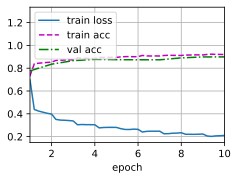

In [ ]:
lr, num_epochs = 0.1, 10
train(model.net, data.get_dataloader(True), data.get_dataloader(False), num_epochs, lr, d2l.try_gpu())

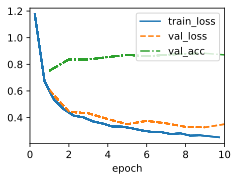

In [ ]:
# Plotting the LeNet Model with 2 more added Fully Connected Layers over 10 Epochs
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model = LeNet_FullyConnLayers(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model, data)

## Model # 5 (Experimentation with Learning Rates)

In [ ]:
class LeNet_LearningRate(d2l.Classifier):  
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.ReLU(),
            nn.LazyLinear(84), nn.ReLU(),
            nn.LazyLinear(num_classes))

model = LeNet_LearningRate()
model.layer_summary((1, 1, 32, 32))
# Printing the total Number of MACs and Parameters for the Model
macs, params = ptflops.get_model_complexity_info(model.net, (1, 32, 32))
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

Conv2d output shape:	 torch.Size([1, 6, 32, 32])
ReLU output shape:	 torch.Size([1, 6, 32, 32])
MaxPool2d output shape:	 torch.Size([1, 6, 16, 16])
Conv2d output shape:	 torch.Size([1, 16, 12, 12])
ReLU output shape:	 torch.Size([1, 16, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 16, 6, 6])
Flatten output shape:	 torch.Size([1, 576])
Linear output shape:	 torch.Size([1, 120])
ReLU output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
ReLU output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])
Sequential(
  82.83 k, 100.000% Params, 605.0 KMac, 100.000% MACs, 
  (0): Conv2d(156, 0.188% Params, 159.74 KMac, 26.404% MACs, 1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU(0, 0.000% Params, 6.14 KMac, 1.016% MACs, )
  (2): MaxPool2d(0, 0.000% Params, 6.14 KMac, 1.016% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(2.42 k, 2.917% Params, 347.9 KMac, 57.505% MACs, 6, 16, kernel_size=(5,

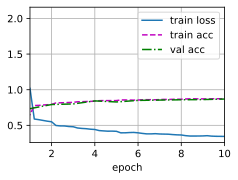

In [ ]:
lr, num_epochs = 0.01, 10
train(model.net, data.get_dataloader(True), data.get_dataloader(False), num_epochs, lr, d2l.try_gpu())

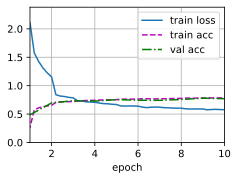

In [ ]:
lr, num_epochs = 0.001, 10
train(model.net, data.get_dataloader(True), data.get_dataloader(False), num_epochs, lr, d2l.try_gpu())

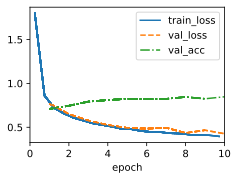

In [ ]:
# Experimenting with 4 different learning rates 1, 0.1, 0.01, and 0.001
trainer = d2l.Trainer(max_epochs=10)
data = d2l.FashionMNIST(batch_size=128)
model = LeNet_Prob1(lr=0.01)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model, data)

## Problem 3

For Problem # 3, the model with the best results from earlier problem will we used and Dropout Layers will be added to test whether it improves the training. 

For all training adjustments, training will be restarted from scratch based on FashionMNIST. The training loss, training accuracy and validation accuracy will be compared against the baseline model in Problem 2. 

In [ ]:
# When the models with different changes were experimented with, the 
# model with changed number of Output Channels 

class LeNet_Prob3(d2l.Classifier):  
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(8, kernel_size=5, padding=2), nn.ReLU(),
            nn.Dropout(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.ReLU(),
            nn.Dropout(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.ReLU(),
            nn.Dropout(0.1),
            nn.LazyLinear(84), nn.ReLU(),
            nn.Dropout(0.1),
            nn.LazyLinear(num_classes))

model = LeNet_Prob3()
model.layer_summary((1, 1, 32, 32))
# Printing the total Number of MACs and Parameters for the Model
macs, params = ptflops.get_model_complexity_info(model.net, (1, 32, 32))
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

Conv2d output shape:	 torch.Size([1, 8, 32, 32])
ReLU output shape:	 torch.Size([1, 8, 32, 32])
Dropout output shape:	 torch.Size([1, 8, 32, 32])
MaxPool2d output shape:	 torch.Size([1, 8, 16, 16])
Conv2d output shape:	 torch.Size([1, 16, 12, 12])
ReLU output shape:	 torch.Size([1, 16, 12, 12])
Dropout output shape:	 torch.Size([1, 16, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 16, 6, 6])
Flatten output shape:	 torch.Size([1, 576])
Linear output shape:	 torch.Size([1, 120])
ReLU output shape:	 torch.Size([1, 120])
Dropout output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
ReLU output shape:	 torch.Size([1, 84])
Dropout output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])
Sequential(
  83.68 k, 100.000% Params, 777.55 KMac, 100.000% MACs, 
  (0): Conv2d(208, 0.249% Params, 212.99 KMac, 27.393% MACs, 1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU(0, 0.000% Params, 8.19 KMac, 1.054% MACs, )
  (2): Dropout(0, 0.

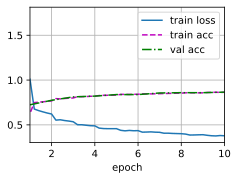

In [ ]:
# Plotting the Best Model's results with a Dropout of 0.1 Added
lr, num_epochs = 0.01, 10
train(model.net, data.get_dataloader(True), data.get_dataloader(False), num_epochs, lr, d2l.try_gpu())

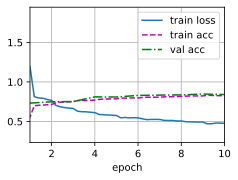

In [ ]:
# Plotting the Best Model's results with a Dropout of 0.3 Added
lr, num_epochs = 0.01, 10
train(model.net, data.get_dataloader(True), data.get_dataloader(False), num_epochs, lr, d2l.try_gpu())

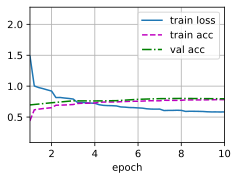

In [ ]:
# Plotting the Best Model's results with a Dropout of 0.5 Added
lr, num_epochs = 0.01, 10
train(model.net, data.get_dataloader(True), data.get_dataloader(False), num_epochs, lr, d2l.try_gpu())

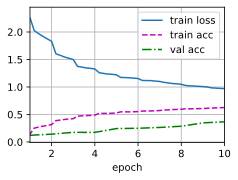

In [ ]:
# Plotting the Best Model's results with a Dropout of 0.7 Added
lr, num_epochs = 0.01, 10
train(model.net, data.get_dataloader(True), data.get_dataloader(False), num_epochs, lr, d2l.try_gpu())

## Problem 4

For Problem 4, a Simplified AlexNet model will be used to train the FashionMNIST dataset. The reason for simplifying the model is that AlexNet may be too complex for the FashionMNIST dataset, in particular, due to the low resolution of the initial images, and hence a simplified modelwill result in faster training while ensuring that the accuracy stays relatively high. 

For all training adjustments, training will be restarted from scratch based on FashionMNIST. The training loss, training accuracy and validation accuracy will be compared against the best model in Problem 2 and 3. Also, the computational saving in the number of operations as well as the number of parameters in the network will be measured.   

In [ ]:
# Alexnet Model Definition
class AlexNet(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(64, kernel_size=5, stride=4, padding=1),
            nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2),
            #nn.LazyConv2d(128, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            #nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            #nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(256, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2), nn.Flatten(),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(p=0.5),
            nn.LazyLinear(4096), nn.ReLU(),nn.Dropout(p=0.5),
            nn.LazyLinear(num_classes))
        self.net.apply(d2l.init_cnn)

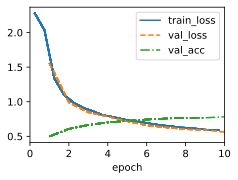

In [ ]:
# Plotting the Alexnet Model over 10 Epochs
model = AlexNet(lr=0.01)
data = d2l.FashionMNIST(batch_size=128, resize=(128, 128))
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
trainer.fit(model, data)

In [ ]:
model = AlexNet()
model.layer_summary((1, 1, 128, 128))
# Printing the total Number of MACs and Parameters for the Model
macs, params = ptflops.get_model_complexity_info(model.net, (1, 128, 128))
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

Conv2d output shape:	 torch.Size([1, 64, 32, 32])
ReLU output shape:	 torch.Size([1, 64, 32, 32])
MaxPool2d output shape:	 torch.Size([1, 64, 15, 15])
MaxPool2d output shape:	 torch.Size([1, 64, 7, 7])
Conv2d output shape:	 torch.Size([1, 256, 7, 7])
ReLU output shape:	 torch.Size([1, 256, 7, 7])
MaxPool2d output shape:	 torch.Size([1, 256, 3, 3])
Flatten output shape:	 torch.Size([1, 2304])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])
Sequential(
  26.41 M, 100.000% Params, 35.38 MMac, 100.000% MACs, 
  (0): Conv2d(1.66 k, 0.006% Params, 1.7 MMac, 4.816% MACs, 1, 64, kernel_size=(5, 5), stride=(4, 4), padding=(1, 1))
  (1): ReLU(0, 0.000% Params, 65.54 KMac, 0.185% MACs, )
  (2): MaxPool2d(0, 0.000% Params, 65.54 KMac, 0.185% MACs

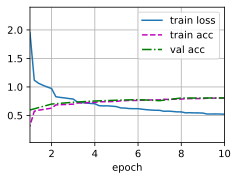

In [ ]:
# Plotting the Best Model's results with a Dropout of 0.5 Added
lr, num_epochs = 0.01, 10
train(model.net, data.get_dataloader(True), data.get_dataloader(False), num_epochs, lr, d2l.try_gpu())

## Problem 5

For Problem 5, A better model that works directly on 28 * 28 Images with better accuracy than AlexNet, but with lower computational complexity will be designed.

In [10]:
class AlexNet_Original(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(64, kernel_size=5, stride=1, padding=2), nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(128, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(256, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), 
            nn.Flatten(),
            nn.LazyLinear(4096), nn.ReLU(), 
            nn.Dropout(p=0.5),
            nn.LazyLinear(4096), nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.LazyLinear(num_classes))
        
        # Initialize the parameters using the default method from d2l
        self.net.apply(d2l.init_cnn)


In [14]:
model = AlexNet_Improved()
model.layer_summary((1, 1, 28, 28))

# Printing the total Number of MACs and Parameters for the Model
macs, params = ptflops.get_model_complexity_info(model.net, (1, 28, 28))
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

Conv2d output shape:	 torch.Size([1, 64, 28, 28])
ReLU output shape:	 torch.Size([1, 64, 28, 28])
MaxPool2d output shape:	 torch.Size([1, 64, 14, 14])
Conv2d output shape:	 torch.Size([1, 128, 14, 14])
ReLU output shape:	 torch.Size([1, 128, 14, 14])
MaxPool2d output shape:	 torch.Size([1, 128, 7, 7])
Conv2d output shape:	 torch.Size([1, 384, 7, 7])
ReLU output shape:	 torch.Size([1, 384, 7, 7])
Conv2d output shape:	 torch.Size([1, 384, 7, 7])
ReLU output shape:	 torch.Size([1, 384, 7, 7])
Conv2d output shape:	 torch.Size([1, 256, 7, 7])
ReLU output shape:	 torch.Size([1, 256, 7, 7])
MaxPool2d output shape:	 torch.Size([1, 256, 3, 3])
Flatten output shape:	 torch.Size([1, 2304])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])
Sequenti

In [15]:
# Resizing the Images to 32x32
data = FashionMNIST(resize = (28, 28))
# Printing the # of Training & Validation Images
print("Training Images   = ", len(data.train))
print("Validation Images = ", len(data.val))

data.train[0][0].shape

Training Images   =  60000
Validation Images =  10000


torch.Size([1, 28, 28])

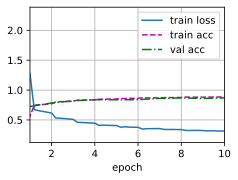

In [16]:
# Plotting the Best Model's results with a Dropout of 0.5 Added
lr, num_epochs = 0.01, 10
train(model.net, data.get_dataloader(True), data.get_dataloader(False), num_epochs, lr, d2l.try_gpu())

In [36]:
class AlexNet_Improved(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(32, kernel_size=5, stride=1, padding=2), nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(64, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            #nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(64, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(32, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), 
            nn.Flatten(),
            nn.LazyLinear(4096), nn.ReLU(), 
            nn.Dropout(p=0.1),
            nn.LazyLinear(4096), nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.LazyLinear(num_classes))
        
        # Initialize the parameters using the default method from d2l
        self.net.apply(d2l.init_cnn)

In [37]:
model = AlexNet_Improved()
model.layer_summary((1, 1, 28, 28))

# Printing the total Number of MACs and Parameters for the Model
macs, params = ptflops.get_model_complexity_info(model.net, (1, 28, 28))
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

Conv2d output shape:	 torch.Size([1, 32, 28, 28])
ReLU output shape:	 torch.Size([1, 32, 28, 28])
MaxPool2d output shape:	 torch.Size([1, 32, 14, 14])
Conv2d output shape:	 torch.Size([1, 64, 14, 14])
ReLU output shape:	 torch.Size([1, 64, 14, 14])
MaxPool2d output shape:	 torch.Size([1, 64, 7, 7])
Conv2d output shape:	 torch.Size([1, 64, 7, 7])
ReLU output shape:	 torch.Size([1, 64, 7, 7])
Conv2d output shape:	 torch.Size([1, 32, 7, 7])
ReLU output shape:	 torch.Size([1, 32, 7, 7])
MaxPool2d output shape:	 torch.Size([1, 32, 3, 3])
Flatten output shape:	 torch.Size([1, 288])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])
Sequential(
  18.11 M, 100.000% Params, 31.51 MMac, 100.000% MACs, 
  (0): Conv2d(832, 0.005% Params, 652.29 KMac

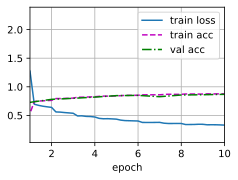

In [38]:
# Plotting the Best Model's results with a Dropout of 0.5 Added
lr, num_epochs = 0.01, 10
train(model.net, data.get_dataloader(True), data.get_dataloader(False), num_epochs, lr, d2l.try_gpu())